# PyGIMLi - DCIP (Century Deposit Dataset)

Using the DCIP (Direct Current, Induced Polarization) solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve problem with a real dataset.

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/pygimli_dcip/pygimli_century_dcip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

Note: This notebook is adapted from a SimPEG example authored by Lindsey Heagy and presented at Transform 2020. [Original Materials](https://curvenote.com/@simpeg/transform-2020-simpeg-tutorial/!6DDumb03Le6D8N8xuJNs)

### Frequency domain vs Time domain measurements of chargeability

References:
- https://gpg.geosci.xyz/content/induced_polarization/induced_polarization_data.html
- Martin, T., Günther, T., Orozco, A. F., & Dahlin, T. (2020). Evaluation of spectral induced polarization field measurements in time and frequency domain. Journal of Applied Geophysics, 180. https://doi.org/10.1016/j.jappgeo.2020.104141
- Mutton, A. J. (2000). The application of geophysics during evaluation of the Century zinc deposit. Geophysics, 65(6), 1946–1960. https://doi.org/10.1190/1.1444878

## 1. Set up environment

We'll do the following:
1. Install PyGIMLi (if on CoLab)
2. Download processed dataset (if on CoLab)
3. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !mamba install -c gimli pygimli=1.3

In [2]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd notebooks/pygimli_dcip/

We will need the following packages:

- `os` to list and load dataset
- `numpy` for matrices and matrix-related functions
- `matplotlib` for plotting
- `pygimli` for forward modelling of the problem
- `cofi` for accessing different inference solvers

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pygimli
import cofi

## 2. Load the data

We will need to download the preprocessed dataset first. This notebook [century_data_preprocessing.ipynb](century_data_preprocessing.ipynb) contains the code for data preprocessing.

In [4]:
dcip_data = np.loadtxt("century_dcip_data.txt")

In [5]:
a_locs = dcip_data[:,0]
b_locs = dcip_data[:,1]
m_locs = dcip_data[:,2]
n_locs = dcip_data[:,3]
dc_obs = dcip_data[:,4]
dc_err = dcip_data[:,5]
ip_obs = dcip_data[:,6]*0.7   # https://gpg.geosci.xyz/content/induced_polarization/induced_polarization_data.html
ip_err = dcip_data[:,7]*0.7
geo_factors = dcip_data[:,8]

location_start = np.min(a_locs)
location_stop = np.max(n_locs)
location_interval = m_locs[1] - m_locs[0]
location_num = int((location_stop - location_start) / location_interval + 1)

location_start, location_stop, location_interval, location_num

(26000.0, 29200.0, 100.0, 33)

In [6]:
def load_leapfrog_geologic_section(filename="century_geologic_section.csv"):
    """
    Load the geologic cross section. 
    """
    fid = open(filename, 'r')
    lines = fid.readlines()
    data = []
    data_tmp = []
    for line in lines[2:]:
        line_data = (line.split(',')[:3])
        if 'End' in line:
            data.append(np.vstack(data_tmp)[:,[0, 2]])
            data_tmp = []
        else:
            data_tmp.append(np.array(line_data, dtype=float))
    return data

geologic_section = load_leapfrog_geologic_section()

## 3. Utility wrappers to PyGIMLi functions

### 3.1. Data container, mesh and forward operator

In [26]:
# inversion mesh bound
x_inv_start = location_start - 1000
x_inv_stop = location_stop + 1000
y_inv_start = -400
y_inv_stop = 0
x_gridmesh = np.linspace(start=x_inv_start, stop=x_inv_stop, num=40)
y_gridmesh = np.linspace(start=y_inv_start, stop=y_inv_stop, num=10)

def data_to_complex(rhoa, phia):
    return rhoa * np.exp(1j * phia)

def data_from_complex(data_complex):
    return np.abs(data_complex), np.arctan2(data_complex.imag, data_complex.real)

# PyGIMLi DataContainerERT
def pygimli_data(a_locs, b_locs, m_locs, n_locs, dc_obs, dc_err, ip_obs, ip_err):
    # --- create empty data container object ---
    pg_data = pygimli.DataContainerERT()
    # create sensor locations
    for sensor in np.linspace(location_start, location_stop, location_num):
        pg_data.createSensor((sensor, 0.0, 0.0))
    # --- add indices for data points ---
    locs_sources = np.vstack((a_locs, b_locs)).T
    locs_receivers = np.vstack((m_locs, n_locs)).T
    for i in range(len(locs_sources)):
        src = locs_sources[i]
        src_idx = (src - location_start) / location_interval
        rec = locs_receivers[i]
        rec_idx = (rec - location_start) / location_interval
        pg_data.createFourPointData(i, src_idx[0], src_idx[1], rec_idx[0], rec_idx[1])
    # --- fill in the observed data and error estimation ---
    pg_data["rhoa"] = dc_obs
    pg_data["err"] = dc_err
    pg_data["phia"] = -ip_obs/1000.     # to make me happy CHECKME
    pg_data["iperr"] = -ip_err/1000.
    # --- create geometric factor k ---
    pg_data["k"] = pygimli.physics.ert.createGeometricFactors(pg_data, numerical=True)
    # --- generate data vals and diag vals of covariance inv matrix in log complex space ---
    data_complex = data_to_complex(pg_data["rhoa"].array(), pg_data["phia"].array())
    # data_complex = pg_data["rhoa"].array() * np.exp(1j * pg_data["phia"].array())
    data_complex_log = np.log(data_complex)
    dc_err_cov_log_inv = 1 / np.log(pg_data["err"]**2)
    ip_err_cov_log_inv = 1 / np.log(pg_data["iperr"]**2)
    data_cov_inv_complex_log = data_to_complex(dc_err_cov_log_inv, ip_err_cov_log_inv)
    # data_cov_inv_complex_log = dc_err_cov_log_inv * np.exp(1j * ip_err_cov_log_inv)
    return pg_data, data_complex_log, data_cov_inv_complex_log

# PyGIMLi ert.ERTManager
def ert_manager(data, verbose=False):
    return pygimli.physics.ert.ERTManager(data, verbose=verbose, useBert=True)

# inversion mesh
def inversion_mesh(ert_mgr):
    inv_mesh = ert_mgr.createMesh(ert_mgr.data)
    # inv_mesh = inv_mesh.createH2()
    ert_mgr.setMesh(inv_mesh)
    return inv_mesh

# mesh used for the original paper
def inversion_mesh_ubc(ert_mgr):
    mesh_ubc = pygimli.meshtools.readMeshIO("century_mesh.vtk")
    ert_mgr.setMesh(mesh_ubc)
    return mesh_ubc

# PyGIMLi ert.ERTModelling
def ert_forward_operator(ert_mgr, data_scheme, inv_mesh):
    forward_operator = ert_mgr.fop
    forward_operator.setComplex(True)
    forward_operator.setData(data_scheme)
    forward_operator.setMesh(inv_mesh, ignoreRegionManager=True)
    return forward_operator

# regularization matrix
def reg_matrix(forward_oprt):
    region_manager = forward_oprt.regionManager()
    region_manager.setConstraintType(2)
    Wm = pygimli.matrix.SparseMapMatrix()
    region_manager.fillConstraints(Wm)
    Wm = pygimli.utils.sparseMatrix2coo(Wm)
    return Wm

def starting_model(ert_mgr, rhoa_val=None, phia_val=None):
    pg_data = ert_mgr.data
    rhoa = np.median(pg_data["rhoa"]) if rhoa_val is None else rhoa_val
    phia = np.median(pg_data["phia"]) if phia_val is None else phia_val
    start_val = pygimli.utils.complex.toComplex(rhoa, phia)
    start_model = np.ones(ert_mgr.paraDomain.cellCount()) * start_val
    start_model_log = np.log(start_model)
    start_model_log_real = pygimli.utils.squeezeComplex(start_model_log)
    return start_model, start_model_log, start_model_log_real

def reference_dc_model():
    return np.loadtxt("century_dc_model.txt")

def reference_ip_model():
    return np.loadtxt("century_ip_model.txt")

# initialise model to have same resistivities as the original inversion result
def starting_model_ref(ert_mgr):
    dc_model_ref = np.loadtxt("century_dc_model.txt")
    assert ert_mgr.paraDomain.cellCount() == len(dc_model_ref), \
        "mesh cell count has to match century reference model length"
    return starting_model(ert_mgr, rhoa_val=dc_model_ref)

### 3.2. Plotting utilities

*Colorbars are plotted separately for compatibility to Colab mpl version.

In [8]:
# plot colorbar for data
def colorbar(ax, cMin, cMax, label, orientation="horizontal"):
    norm = mpl.colors.Normalize(cMin, cMax)
    sm = plt.cm.ScalarMappable(norm=norm)
    cb = plt.colorbar(sm, orientation=orientation, ax=ax)
    cb.set_label(label)
    cb.set_ticks(np.arange(cMin, cMax+0.1, (cMax-cMin)/5))
    
def plot_data(pg_data, data_complex, title):      # takes in data in complex normal space
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    data_dc, data_ip = data_from_complex(data_complex)
    data_ip *= 1000
    # apparent resistivity
    # data_dc = np.abs(data_complex)
    pygimli.physics.ert.showERTData(
        pg_data, 
        vals=data_dc, 
        # label=r'$\rho_a~[\Omega$m]', 
        ax=axes[0], 
        colorBar=False,
    )
    colorbar(axes[0], min(data_dc), max(data_dc), r'$\rho_a~[\Omega$m]')
    axes[0].set_xlabel("Horizontal Distance (m)")
    axes[0].set_ylabel("Dipole Dipole Separation (m)")
    axes[0].set_title("Apparent Resistivity")
    # apparent chargeability
    # data_ip = np.arctan2(data_complex.imag, data_complex.real) * 1000
    pygimli.physics.ert.showERTData(
        pg_data,
        vals=data_ip,
        # label=r'$\phi_a~[mrad]$',
        ax=axes[1],
        colorBar=False,
    )
    colorbar(axes[1], min(data_ip), max(data_ip), r'$\phi_a~[mrad]$')
    axes[1].set_xlabel("Horizontal Distance (m)")
    axes[1].set_ylabel("Dipole Dipole Separation (m)")
    axes[1].set_title("Apparent Chargeability")
    
def plot_mesh(mesh, title="Mesh used for inversion"):
    _, ax = plt.subplots(1, 1)
    pygimli.show(mesh, showMesh=True, markers=True, colorBar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Northing (m)")
    ax.set_ylabel("Elevation (m)")

def plot_model(mesh, model_vec, title):
    fig, axes = plt.subplots(2, 1,figsize=(12,5))
    pygimli.show(mesh, data=np.abs(model_vec), label=r"$\Omega m$", ax=axes[0])
    axes[0].set_xlim(x_inv_start, x_inv_stop)
    axes[0].set_ylim(y_inv_start, y_inv_stop)
    axes[0].set_title("Resistivity")
    pygimli.show(mesh, data=np.arctan2(np.imag(model_vec), np.real(model_vec)) * 1000, label=r"mrad", ax=axes[1])
    axes[1].set_xlim(x_inv_start, x_inv_stop)
    axes[1].set_ylim(y_inv_start, y_inv_stop)
    axes[1].set_title("Chargeability")
    fig.suptitle(title)

def plot_result(inv_result, ert_mgr, title=None):
    # convert back to normal space from log space
    model = np.exp(inv_result.model)
    # add title
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    if title is not None:
        fig.suptitle(title, fontsize=16)
    # plot inferred model
    plot_model(ert_mgr.paraDomain, model, "Inferred model", False, ax)
    ax.set_ylim(y_inv_start, y_inv_stop)
    # plot the data
    _, axes = plt.subplots(1, 2, figsize=(12,4))
    # plot synthetic data
    d_scheme = ert_mgr.data
    dobs = d_scheme["rhoa"]
    d = forward_oprt.response(model)
    plot_data(d_scheme, data_vals=d, title="Synthetic data", ax=axes[0], cMin=min(dobs), cMax=max(dobs))
    # plot observed data
    plot_data(d_scheme, data_vals=dobs, title="Observed data", ax=axes[1])

def plot_comparison(mesh1, model1, title1, mesh2, model2, title2, color_range):
    fig, axes = plt.subplots(2, 1, figsize=(10,6))
    pygimli.show(
        mesh1, 
        data=model1,
        ax=axes[0],
        label=r"$\Omega m$", 
        cMin=color_range[0],
        cMax=color_range[1],
        colorBar=False
    )
    axes[0].set_xlabel("Horizontal Distance (m)")
    axes[0].set_ylabel("Elevation (m)")
    axes[0].set_xlim(mesh2.xMin(), mesh2.xMax())
    axes[0].set_ylim(y_inv_start, y_inv_stop)
    axes[0].set_title(title1)
    pygimli.show(
        mesh2, 
        data=model2,
        ax=axes[1],
        label=r"$\Omega m$", 
        cMin=color_range[0],
        cMax=color_range[1],
        colorBar=False
    )
    axes[1].set_xlabel("Horizontal Distance (m)")
    axes[1].set_ylabel("Elevation (m)")
    axes[1].set_ylim(y_inv_start, y_inv_stop)
    axes[1].set_title(title2)
    colorbar(axes, color_range[0], color_range[1], r"$\Omega$m")

## 4. PyGIMLi problem setup

### 4.1. Data container

In [9]:
pg_data, data_complex_log, data_cov_inv_complex_log = pygimli_data(a_locs, b_locs, m_locs, n_locs, dc_obs, dc_err, ip_obs, ip_err)
pg_data

16/11/22 - 14:12:30 - pyGIMLi - INFO - Cache /home/jiawen/opt/mambaforge/envs/cofi_env/lib/python3.10/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (6.0s x 6): /home/jiawen/.cache/pygimli/17680588544488343495


Data: Sensors: 33 data: 151, nonzero entries: ['a', 'b', 'err', 'iperr', 'k', 'm', 'n', 'phia', 'rhoa', 'valid']

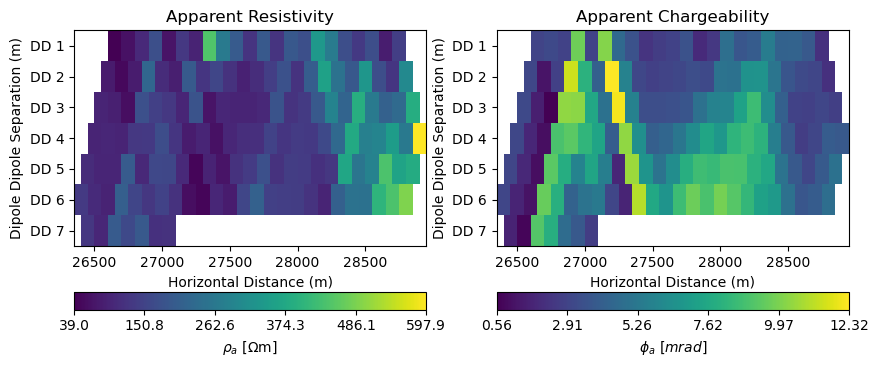

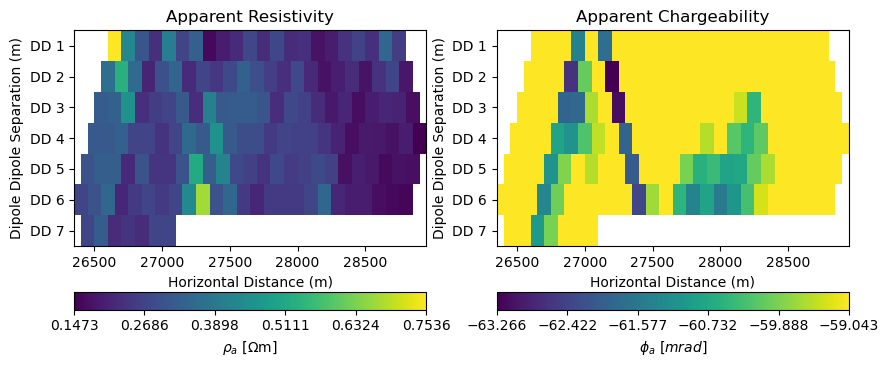

In [10]:
plot_data(pg_data, np.exp(data_complex_log), "Observed Data")
plot_data(pg_data, data_cov_inv_complex_log, "Data covariance inverse weighting in log space")

### 4.2. ERT manager

In [11]:
ert_mgr = ert_manager(pg_data)

### 4.3. Inversion mesh

In [12]:
# inv_mesh = inversion_mesh(ert_mgr)
inv_mesh = inversion_mesh_ubc(ert_mgr)

16/11/22 - 14:12:31 - pyGIMLi - INFO - Found 1 regions.


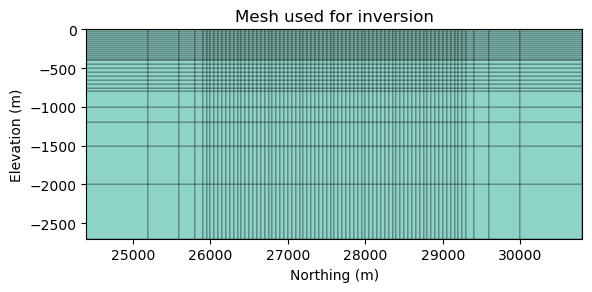

In [13]:
plot_mesh(inv_mesh)

### 4.4. Forward operator

In [14]:
forward_oprt = ert_forward_operator(ert_mgr, pg_data, inv_mesh)

### 4.5. Regularization matrix

In [15]:
Wm = reg_matrix(forward_oprt)

### 4.6. Starting model

16/11/22 - 14:12:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
16/11/22 - 14:12:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


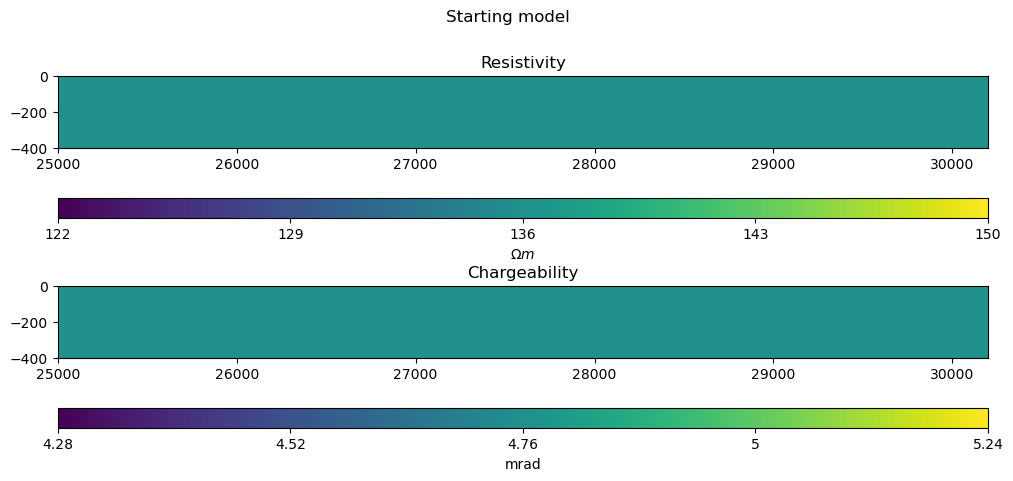

In [16]:
start_model, start_model_log, start_model_log_real = starting_model(ert_mgr)

plot_model(ert_mgr.paraDomain, start_model, "Starting model")

## 5. Create utility functions to pass to CoFI

In [17]:
# Utility Functions (additional)

def _ensure_numpy(model):
    if "torch.Tensor" in str(type(model)):
        model = model.cpu().detach().numpy()
    return model

# accepts model in log complex space -> produces y in log complex space
def get_response(model_log, fop):
    model = np.exp(model_log)
    model = _ensure_numpy(model)
    model_re_im = pygimli.utils.squeezeComplex(model)
    synth = np.array(fop.response(model_re_im))
    return np.log(pygimli.utils.toComplex(synth))

# accepts model in log complex space -> produces Jac in log-log complex space
def get_jacobian(model_log, fop):
    model = np.exp(model_log)
    model = _ensure_numpy(model)
    model_re_im = pygimli.utils.squeezeComplex(model)
    J_block = fop.createJacobian(model_re_im)
    J_re = np.array(J_block.mat(0))
    J_im = np.array(J_block.mat(1))
    J = J_re + 1j * J_im
    y_synth_log = get_response(model_log, fop)
    J_loglog = J / np.exp(y_synth_log[:,np.newaxis]) * model[np.newaxis,:]
    return J_loglog

# accepts model/data in log complex space -> produces residuals in log complex space
def get_residuals(model_log, data_log, fop):
    y_synth_log = get_response(model_log, fop)
    return data_log - y_synth_log

# accepts model in log real space -> produces objective value in log real space
def get_objective(model_log_real, data_log, fop, lamda, Wm, data_cov_inv_complex_log):
    # model_log_real to complex space
    model_log = pygimli.utils.complex.toComplex(model_log_real)
    # calculate data misfit
    res = get_residuals(model_log, data_log, fop)
    data_misfit = res.T.dot(res * data_cov_inv_complex_log)
    # calculate regularization term
    weighted_model_log = Wm.dot(model_log)
    reg = lamda * weighted_model_log.T.dot(weighted_model_log)
    # sum up
    result = np.abs(data_misfit + reg)
    return result

# accepts model in log real space -> produces gradient vector in log real space
def get_gradient(model_log_real, data_log, fop, lamda, Wm, data_cov_inv_complex_log):
    # model_log_real to complex space
    model_log = pygimli.utils.complex.toComplex(model_log_real)
    # calculate gradient for data misfit
    res = get_residuals(model_log, data_log, fop)
    jac = get_jacobian(model_log, fop)
    data_misfit_grad = - jac.conj().T.dot(res)
    # calculate gradient for regularization term
    reg_grad = lamda * Wm.T.dot(Wm).dot(model_log)
    # sum up
    grad_complex = data_misfit_grad + reg_grad
    grad_real = pygimli.utils.squeezeComplex(grad_complex)
    grad_real = np.concatenate((np.real(grad_complex), np.imag(grad_complex)))
    return grad_real

# accepts model in log real space -> produces hessian matrix in log real space
def get_hessian(model_log_real, data_log, fop, lamda, Wm, data_cov_inv_complex_log):
    # model_log_real to complex space
    nparams = len(model_log_real)//2
    model_log = pygimli.utils.complex.toComplex(model_log_real)
    # calculate hessian for data misfit
    res = get_residuals(model_log, data_log, fop)
    jac = get_jacobian(model_log, fop)
    data_misfit_hessian = - jac.conj().T.dot(jac)
    # calculate hessian for regularization term
    reg_hessian = lamda * Wm.T.dot(Wm)
    # sum up
    hessian_complex = data_misfit_hessian + reg_hessian
    hessian_real = np.zeros((2*nparams, 2*nparams))
    hessian_real[:nparams,:nparams] = np.real(hessian_complex)
    hessian_real[:nparams,nparams:] = -np.imag(hessian_complex)
    hessian_real[nparams:,:nparams] = np.imag(hessian_complex)
    hessian_real[nparams:,nparams:] = np.real(hessian_complex)
    return hessian_real

In [25]:
# test
try:
    get_response(start_model_log, forward_oprt)
except RuntimeError:
    print("run again")
    get_response(start_model_log, forward_oprt)

In [19]:
# test
obj_val = get_objective(start_model_log_real, data_complex_log, forward_oprt, 0.0001, Wm, data_cov_inv_complex_log)
obj_val

42.906898683610684

In [20]:
# test
gradient = get_gradient(start_model_log_real, data_complex_log, forward_oprt, 0.0001, Wm, data_cov_inv_complex_log)
gradient.shape, gradient

*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


((4408,),
 array([-5.10695300e-04, -3.95393128e-04, -2.65589724e-04, ...,
        -1.25448139e-05, -2.18941014e-06,  6.36493612e-07]))

In [21]:
# test
hessian = get_hessian(start_model_log_real, data_complex_log, forward_oprt, 0.0001, Wm, data_cov_inv_complex_log)
hessian.shape, hessian

*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


((4408, 4408),
 array([[ 5.97613862e-04, -5.01660419e-04,  9.89611775e-05, ...,
          6.37378308e-18,  1.11736069e-18,  4.60366718e-20],
        [-5.01660419e-04,  1.19884129e-03, -6.00725221e-04, ...,
          2.42297999e-18,  3.50788324e-19, -2.33706021e-20],
        [ 9.89611775e-05, -6.00725221e-04,  1.19954596e-03, ...,
          8.06617181e-19,  7.38466497e-20, -3.18282445e-20],
        ...,
        [ 6.37378308e-18,  2.42297999e-18,  8.06617181e-19, ...,
          1.10853030e-03, -6.25995570e-04,  9.55492152e-05],
        [ 1.11736069e-18,  3.50788324e-19,  7.38466497e-20, ...,
         -6.25995570e-04,  1.19233852e-03, -5.01370440e-04],
        [ 4.60366718e-20, -2.33706021e-20, -3.18282445e-20, ...,
          9.55492152e-05, -5.01370440e-04,  5.99740338e-04]]))

## 6. Run inversion with CoFI

### 6.1. Simple Newton

In [22]:
# hyperparameters
lamda = 0.00001

# CoFI - define BaseProblem
dcip_problem = cofi.BaseProblem()
dcip_problem.name = "DC-IP defined through PyGIMLi"
dcip_problem.set_objective(get_objective, args=[data_complex_log, forward_oprt, Wm, lamda, data_cov_inv_complex_log])
dcip_problem.set_gradient(get_gradient, args=[data_complex_log, forward_oprt, Wm, lamda, data_cov_inv_complex_log])
dcip_problem.set_hessian(get_hessian, args=[data_complex_log, forward_oprt, Wm, lamda, data_cov_inv_complex_log])
dcip_problem.set_initial_model(start_model_log_real)

In [ ]:
# test
dcip_problem.objective(start_model_log_real)

In [23]:
# CoFI - define InversionOptions
inv_options = cofi.InversionOptions()
inv_options.set_tool("cofi.simple_newton")
inv_options.set_params(max_iterations=60, step_length=0.01)

# CoFI - define Inversion and run
inv = cofi.Inversion(dcip_problem, inv_options)
inv_result = inv.run()

print(f"\nNumber of objective function evaluations: {inv_result.n_obj_evaluations}")
print(f"Number of gradient function evaluations: {inv_result.n_grad_evaluations}")
print(f"Number of hessian function evaluations: {inv_result.n_hess_evaluations}")

InvocationError: exception while calling your objective. Check exception details from message above. If not sure, please report this issue at https://github.com/inlab-geo/cofi/issues

In [ ]:
plot_result(inv_result, ert_mgr)

#### 6.1.1 Compare with UBC results

In [ ]:
import meshio

mesh_ubc = pygimli.meshtools.readMeshIO("century_mesh.vtk")
model_ubc = np.loadtxt("century_ubc_model.txt")

In [ ]:
model = np.exp(inv_result.model)

In [ ]:
color_range = (30, 1000)

plot_comparison(
    mesh_ubc, 
    model_ubc, 
    "UBC reference model", 
    ert_mgr.paraDomain, 
    model, 
    "Our inferred model",
    color_range
)

### 6.2. SciPy trust-ncg optimizer

In [ ]:
#@title Utility Callback Function (hidden, no need to change)

class CallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        if self.x is not None:
            print(f"  model change: {np.linalg.norm(xk - self.x)}")
        print(f"  objective value: {ert_problem.objective(xk)}")
        self.x = xk
        self.i += 1

In [ ]:
# CoFI - define InversionOptions
inv_options2 = cofi.InversionOptions()
inv_options2.set_tool("torch.optim")
inv_options2.set_params(algorithm="Rprop", num_iterations=30)

# CoFI - define Inversion and run
inv = cofi.Inversion(ert_problem, inv_options2)
inv_result2 = inv.run()

print(f"\nNumber of objective function evaluations: {inv_result.n_obj_evaluations}")
print(f"Number of gradient function evaluations: {inv_result.n_grad_evaluations}")

In [ ]:
plot_result(inv_result2, ert_mgr)

#### 6.2.1 Compare with UBC results

In [ ]:
plot_comparison(
    mesh_ubc, 
    model_ubc, 
    "UBC reference model", 
    ert_mgr.paraDomain, 
    np.exp(inv_result2.model), 
    "Our inferred model",
    color_range
)

---
## Watermark

In [31]:
watermark_list = ["cofi", "numpy", "scipy", "pygimli", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev21
numpy 1.21.6
scipy 1.9.1
pygimli 1.2.6
matplotlib 3.5.3
